In [1]:
import os
import glob
import zipfile
import functools

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

session = tf.Session(config=config)

In [2]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [3]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [4]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [5]:
save_model_path = '/home/mdj/Development/SAR-Ship-Detection/weights.hdf5'

# Alternatively, load the weights directly: model.load_weights(save_model_path)
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

In [6]:
ais_filename = '/home/mdj/Datasets/ais/aisdk_20181006.csv'
sar_filename= '/home/mdj/S1A_IW_SLC__1SDV_20181006T054021_20181006T054048_024011_029F96_1702_Orb_Cal_deb_ML_Spk_TC.tif'

img_win = (256, 256)


In [7]:
with rasterio.open(sar_filename) as sar_ds:
    print(sar_ds.width, sar_ds.height)
    print(sar_ds.crs)
    print(sar_ds.transform)
    print(sar_ds.count)
    print(sar_ds.indexes)
    band1 = sar_ds.read(1)

36467 15315
+init=epsg:4326
| 0.00, 0.00, 7.32|
| 0.00,-0.00, 58.44|
| 0.00, 0.00, 1.00|
1
(1,)


In [122]:
def extract_image_at_coord(ds,lon,lat,width,height):
    centoid = ds.index(lon, lat)
    dx, dy = ds.res  
    snip = band1[centoid[0]-int(height//2):centoid[0]+int(height//2), centoid[1]-int(width//2):centoid[1]+int(width//2)]
    return snip, [centoid[0]-int(height//2),centoid[0]+int(height//2), centoid[1]-int(width//2), centoid[1]+int(width//2)]

def extract_image_at_px(ds,x,y,width,height):
    centoid = (x,y)
    dx, dy = ds.res  
    snip = band1[centoid[0]-int(height//2):centoid[0]+int(height//2), centoid[1]-int(width//2):centoid[1]+int(width//2)]
    return snip, [centoid[0]-int(height//2),centoid[0]+int(height//2), centoid[1]-int(width//2), centoid[1]+int(width//2)]



[5932, 6188, 11753, 12009]


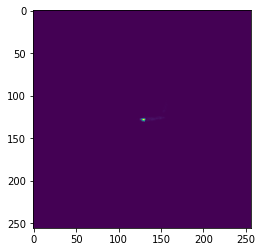

In [112]:
pos = (8.89347, 57.63367)
# pos_time = datetime.datetime.strptime("2018-10-06 05:40:31:251 AM", '%Y-%m-%d %I:%M:%S:%f %p')
# print(pos_time)
img, coords = extract_image_at_coord(sar_ds, pos[0], pos[1], 256, 256)
print(coords)
plt.imshow(img)

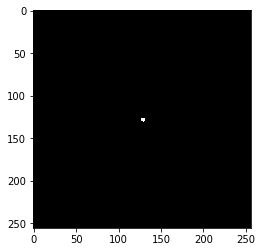

In [119]:
im2arr =  np.expand_dims(np.transpose(np.array([img,img,img])), axis=0)
# print(im2arr.shape)
# Predicting the Test set results
y_pred = model.predict(im2arr)[0]
ytst = (256/np.max(np.transpose(y_pred[:,:,0]))*np.transpose(y_pred[:,:,0]))
plt.imshow(np.transpose(y_pred[:,:,0]))
imgc = plt.imshow(ytst,cmap='gray')
# print(imgc.get_array().shape)
# np.histogram(ytst)

In [120]:
def latlon(ds, coord_base, pos):
    x = coord_base[0] + pos[0]
    y = coord_base[2] + pos[1]
    return ds.xy(x,y)

In [121]:
pimg = ytst

# plt.hist(pimg.ravel(),256,[0.1,256]); plt.show()

indices = np.where(ytst > 250)
# print(np.mean(indices[0]), np.mean(indices[1][0]))


# print(indices)
# np.max(pimg)
latlon(sar_ds, coords, (np.mean(indices[0]), np.mean(indices[1][0])))

(8.89329917449193, 57.633611068851145)

In [133]:
coordinates = []
for x in range(256//2, sar_ds.shape[0], 256):
    for y in range(256//2, sar_ds.shape[1], 256):
        chip, coords = extract_image_at_px(sar_ds, x, y, 256, 256)
        
        if chip.shape != (256, 256):
            continue
            
        im2arr =  np.expand_dims(np.transpose(np.array([chip,chip,chip])), axis=0)
        y_pred = model.predict(im2arr)[0]
        ytst = (256/np.max(np.transpose(y_pred[:,:,0]))*np.transpose(y_pred[:,:,0]))
#         plt.imshow(np.transpose(y_pred[:,:,0]))
#         imgc = plt.imshow(ytst,cmap='gray')
        indices = np.where(ytst > 250)
        # print(np.mean(indices[0]), np.mean(indices[1][0]))
        if np.mean(indices[0]) > 0 and np.mean(indices[1]) > 0 and 254 not in indices[0] and 254 not in indices[1] and 1 not in indices[0] and 1 not in indices[1]:
#             print(indices)
            coordinates.append(latlon(sar_ds, coords, (np.mean(indices[0]), np.mean(indices[1][0]))))
        

In [134]:
with open("coord_predicted.csv", 'w') as fo:
    fo.write("lon,lat\n")
    for coord in coordinates:
        fo.write("%f,%f\n" % coord)